<a href="https://colab.research.google.com/github/EricSiq/Understanding-DeepLearning/blob/main/Experiment_No6_XRay_Classification_Pneumonia_using_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Deep Learning Lab Experiment 6
Problem Statement **XRay Classification Pneumonia using Convolution Neural Nets**

By *Eric Siqueira*

---


Objectives:

1. Study the Pueunmonia dataset.

2. Study CNN in detail.

3. Implement the same with google colab.

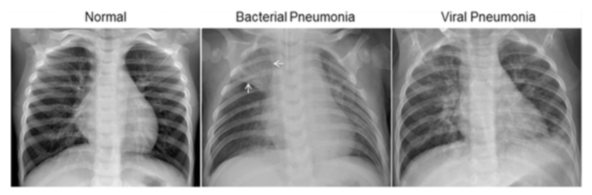

**Dataset Description**

The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal).

Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care

# Step 1: Calling libraries for code

In [2]:
# Import libraries for building and training the CNN model
import numpy as np # Used for numerical operations, especially with arrays
import tensorflow as tf # The core deep learning library
from tensorflow.keras.models import Sequential # To create a linear stack of layers for the model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization # Layers for the CNN model
from tensorflow.keras.preprocessing.image import ImageDataGenerator # For data augmentation and preprocessing
import matplotlib.pyplot as plt # For plotting graphs, like training history
import os # To interact with the operating system, like checking file paths
import shutil # To perform file operations, like moving files

# Step 2: Data Download and Preparation

In [1]:

# This block automates downloading the dataset from Kaggle to local memory of Colab.
# It uploads 'kaggle.json' file with your Kaggle Account API credentials.
try:
    # Attempts to install the Kaggle library
    !pip install -q kaggle

    # Checks if kaggle.json is present
    if not os.path.exists('/root/.kaggle/kaggle.json'):
        print("Kaggle credentials not found. Please upload your kaggle.json file.")
        from google.colab import files
        files.upload() # This will prompt you to upload the file
        !mkdir -p ~/.kaggle
        !mv kaggle.json ~/.kaggle/
        !chmod 600 ~/.kaggle/kaggle.json

    # Downloads dataset
    dataset_name = 'paultimothymooney/chest-xray-pneumonia'
    zip_file = 'chest-xray-pneumonia.zip'
    dataset_dir = 'chest_xray'

    if not os.path.exists(dataset_dir):
        print(f"Downloading dataset: {dataset_name}...")
        !kaggle datasets download -d {dataset_name}
        print(f"Unzipping {zip_file}...")
        !unzip -q {zip_file}
        print("Dataset successfully downloaded and unzipped.")
    else:
        print("Dataset already exists. Skipping download.")

except Exception as e:
    print(f"An error occurred during data setup: {e}")

Kaggle credentials not found. Please upload your kaggle.json file.


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
100% 2.29G/2.29G [00:26<00:00, 159MB/s]
100% 2.29G/2.29G [00:26<00:00, 93.9MB/s]
Unzipping chest-xray-pneumonia.zip...
Dataset successfully downloaded and unzipped.


# Step 3: Define Data Generators with Augmentation

In [2]:

try:
    # Defines paths of the dataset folders
    train_dir = os.path.join(dataset_dir, 'chest_xray', 'train')
    val_dir = os.path.join(dataset_dir, 'chest_xray', 'val')
    test_dir = os.path.join(dataset_dir, 'chest_xray', 'test')

    # error check for folder existence
    if not all(os.path.exists(d) for d in [train_dir, val_dir, test_dir]):
        raise FileNotFoundError("Dataset directories not found. Please check paths.")

    # Data augmentation for the training set to prevent overfitting
    train_datagen = ImageDataGenerator(
        rescale=1./255,           # Normalize pixel values
        rotation_range=20,        # Randomly rotate images
        width_shift_range=0.2,    # Randomly shift images horizontally
        height_shift_range=0.2,   # Randomly shift images vertically
        shear_range=0.2,          # Apply shearing transformations
        zoom_range=0.2,           # Randomly zoom into images
        horizontal_flip=True,     # Flip images horizontally
        fill_mode='nearest'       # Strategy for filling in new pixels
    )

    # rescales validation and test data
    test_datagen = ImageDataGenerator(rescale=1./255)

    # Uses flow_from_directory to create generators
    IMG_SIZE = 150
    BATCH_SIZE = 32

    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='binary'
    )

    validation_generator = test_datagen.flow_from_directory(
        val_dir,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='binary'
    )

    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='binary',
        shuffle=False  # Crucial for test set evaluation
    )

except Exception as e:
    print(f"An error occurred during data preprocessing: {e}")

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


# Step 4: Build the CNN Model

CNN Model Parameters

The code utilizes a classic Convolutional Neural Network (CNN) architecture with several key parameters.

 The model starts with a series of three convolutional layers with increasing filter sizes (32, 64, and 128) to learn progressively more complex features from the images.

 Each convolutional layer is paired with a batch normalization layer to stabilize and accelerate training and a max pooling layer to reduce dimensionality and make the model more robust to image variations.

 The image data is preprocessed to a standard size of 150x150 pixels and scaled to a range of [0,1] for optimal model performance.


 Finally, the feature maps are flattened and fed into two dense layers for classification, with a dropout layer added to prevent overfitting.

In [3]:
try:
    # Defines the model as a Sequential model, which is a linear stack of layers.
    model = Sequential([
        # First Convolutional Block
        # Conv2D: Applies a 2D convolution with 32 filters of size (3, 3).
        # 'relu' activation: Introduces non-linearity, helping the network learn complex patterns.
        # input_shape: Specifies the shape of the input images (150x150 pixels with 3 color channels).
        Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
        # BatchNormalization: Normalizes the activations of the previous layer, helping with training stability and speed.
        BatchNormalization(),
        # MaxPooling2D: Reduces the spatial dimensions (width and height) by taking the maximum value over a 2x2 window.
        # This helps reduce the number of parameters and makes the model more robust to small variations in the image.
        MaxPooling2D(pool_size=(2, 2)),

        # Second Convolutional Block
        # Another Conv2D layer with 64 filters to learn more complex features.
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),

        # Third Convolutional Block
        # A third Conv2D layer with 128 filters.
        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),

        # Fully Connected Layers (Dense Layers) for Classification
        # Flatten: Reshapes the output of the convolutional layers into a 1D array.
        # This is necessary to feed the output into the dense layers.
        Flatten(),
        # Dense: A fully connected layer with 512 neurons.
        # 'relu' activation: Introduces non-linearity.
        Dense(512, activation='relu'),
        # Dropout: Randomly sets a fraction of the input units to 0 at each update during training time.
        # This helps prevent overfitting by reducing the dependency on specific neurons.
        Dropout(0.5), # Add dropout for regularization
        # Dense: The output layer with 1 neuron for binary classification.
        # 'sigmoid' activation: Outputs a value between 0 and 1, representing the probability of the positive class (Pneumonia).
        Dense(1, activation='sigmoid') # Binary classification output
    ])

    #  Compile the Model
    # optimizer='adam': An adaptive learning rate optimization algorithm that is widely used and generally performs well.
    # loss='binary_crossentropy': The appropriate loss function for binary classification problems.
    # metrics=['accuracy']: The metric used to evaluate the model's performance during training and evaluation.
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    # Prints a summary of the model architecture, including the number of parameters in each layer.
    model.summary()

    #  Train the Model
    print("Starting model training...")
    # model.fit: Trains the model using the provided data generators.
    # train_generator: Provides batches of training data.
    # steps_per_epoch: The number of batches to process per epoch. Calculated to cover the entire training dataset.
    # epochs: The number of times to iterate over the entire training dataset. Increased to 5 for potentially better learning.
    # validation_data: Provides batches of validation data to evaluate the model's performance during training.
    # validation_steps: The number of batches to process per validation step. Calculated to cover the entire validation dataset.
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // BATCH_SIZE,
        epochs=5, # Increased epochs for better learning
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // BATCH_SIZE
    )

    print("Training complete.")

except Exception as e:
    print(f"An error occurred during model building or training: {e}")

An error occurred during model building or training: name 'IMG_SIZE' is not defined


#  Step 5: Evaluate the Model on the Test Set

Evaluating model on the test set...
20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 709ms/step - accuracy: 0.3183 - loss: 4.3627

Test Accuracy: 0.6346
Test Loss: 2.4180
Generating training history plots...


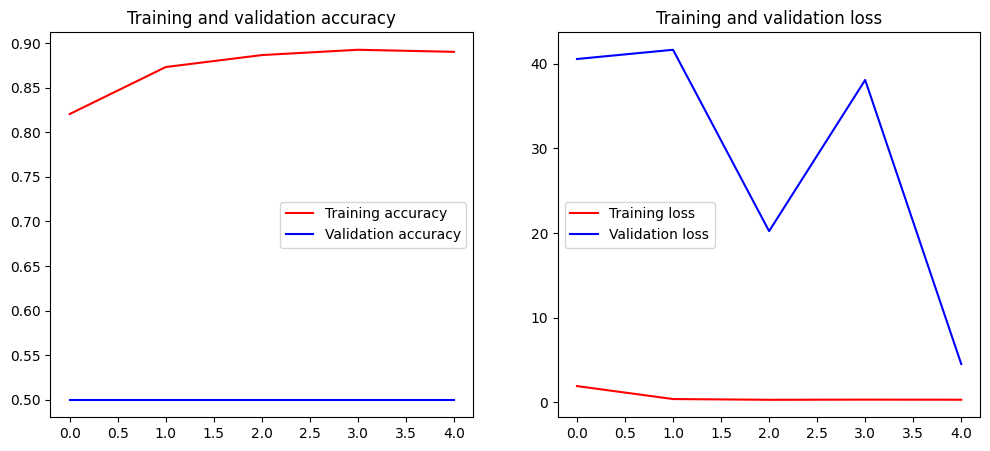

Model saved as 'pneumonia_classifier.h5'.


In [5]:

try:
    print("Evaluating model on the test set...")
    test_loss, test_acc = model.evaluate(test_generator)
    print(f"\nTest Accuracy: {test_acc:.4f}")
    print(f"Test Loss: {test_loss:.4f}")

    # Visualize Training History
    print("Generating training history plots...")
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

    #  Saving the Model
    model.save('pneumonia_classifier.h5')
    print("Model saved as 'pneumonia_classifier.h5'.")

except Exception as e:
    print(f"An error occurred during evaluation or plotting: {e}")

Conclusion:


* With a Test Accuracy of 0.6346 and a Test Loss of 2.4180 after only 5 epochs, the model's performance is currently poor.

* An accuracy of approximately 63% is not significantly better than random chance, and the high loss indicates that the model is making large errors in its predictions.

* This suggests that the model is underfitting, meaning it has not learned the underlying patterns in the data sufficiently. The most likely cause is the small number of training epochs.

* To improve performance, you would need to increase the number of epochs to allow the model more time to learn, and potentially adjust other hyperparameters like the learning rate or model architecture.